In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from metpy.calc import dewpoint_from_specific_humidity, equivalent_potential_temperature, potential_temperature
from metpy.units import units as munits
from tqdm.auto import tqdm
import os
from numba import njit
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import FuncFormatter
from setup_mpl_tex import setup_mpl_tex, set_size
from matplotlib import gridspec

In [2]:
grid = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline/heuer_atm_amip_R2B4_vlvl60_baseline_vgrid_atm_vgrid_ml.nc')
zsfc = grid.zghalf.isel(height=-1)
clat = grid.clat

In [3]:
land_frac = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline/bc_land_frac.nc').land

In [4]:
def get_ds_from_basepath(basepath):
    file_list = sorted(glob(os.path.join(basepath, '*atm_3d_inst_ml*')))
    print(f'Found {len(file_list)} sample files')
    timesteps = range(len(file_list))#range(12)
    ds = xr.concat(
        [xr.open_dataset(file_list[it]) for it in timesteps],
        dim='time')
    ds2d = xr.concat(
        [xr.open_dataset(file_list[it].replace('atm_3d', 'atm_2d')) for it in timesteps],
        dim='time')
    dsphy = xr.concat(
        [xr.open_dataset(file_list[it].replace('atm_3d', 'phy_3d')) for it in timesteps],
        dim='time')

    ds['pr'] = ds2d['pr']
    ds['prcr'] = ds2d['prcr']
    ds['prcs'] = ds2d['prcs']
    ds['extra_2d5'] = ds2d['extra_2d5']
    ds['ts'] = ds2d['ts']
    ds['prw'] = ds2d['prw'].clip(min=0)
    ds['tend_ta_cnv'] = dsphy['tend_ta_cnv']
    ds['tend_qhus_cnv'] = dsphy['tend_qhus_cnv']
    ds['tend_qclw_cnv'] = dsphy['tend_qclw_cnv']
    ds['tend_qcli_cnv'] = dsphy['tend_qcli_cnv']
    ds['q_cnv'] = dsphy['q_cnv']
    if 'rtype' in list(ds2d):
        ds['rtype'] = ds2d['rtype']
    return ds

prw_label = 'CWV (kg m-2)'

ds_tiedtke = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline/')
ds_ml = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml/')
# ds_ml = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pinn385weight0.1/')

# ds_mix  = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1/')
# ds_mix2 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_80p1_pinn385weight0.1/')
# ds_mix3 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_70p1_pinn385weight0.1/')
ds_mix  = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1_extra2d5fix/')
ds_mix2 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_80p1_pinn385weight0.1_extra2d5fix/')
# ds_mix2 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.5/')
ds_mix3 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_70p1_pinn385weight0.1_extra2d5fix/')
label_mix1 = 'Mixed:10-60'#'10p0_60p1_0.1$\\alpha$'
label_mix2 = 'Mixed:10-80'#'10p0_80p1_0.1$\\alpha$'
label_mix3 = 'Mixed:10-70'#'10p0_70p1_0.1$\\alpha$'#'30p0_90p1_pinn0.5'#

# ds_mix2 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_20p0_80p1_pinn385weight0.5/')
# ds_mix2 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_30p0_90p1_pinn385weight0.5/')
# ds_mix3 = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_80p1_pinn385weight0.5/')
# # ds_mix = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1/')
# label_mix1 = '20p0_80p1_0.5$\\alpha$'
# label_mix2 = '30p0_90p1_0.5$\\alpha$'
# label_mix3 = '10p0_80p1_0.5$\\alpha$'#'30p0_90p1_pinn0.5'#

Found 12 sample files
Found 12 sample files
Found 12 sample files
Found 12 sample files
Found 12 sample files


In [5]:
for name in ds_tiedtke:
    # if 'cnv' in name:
    print(name)

height_bnds
zg
ps
pfull
rho
ta
ua
va
wap
hus
clw
cli
hur
cl
pr
prcr
prcs
extra_2d5
ts
prw
tend_ta_cnv
tend_qhus_cnv
tend_qclw_cnv
tend_qcli_cnv
q_cnv
rtype


In [6]:
zg = grid.zg.values
zghalf = grid.zghalf.values
dzghalf = grid.dzghalf.values

zghalf.shape, dzghalf.shape, zg.shape

((61, 20480), (60, 20480), (60, 20480))

In [7]:
# pfull = ds_tiedtke.pfull#.values * munits.pascal
# ta = ds_tiedtke.ta#.values * munits.kelvin
# hus = ds_tiedtke.hus#.values
# ts = ds_tiedtke.ts
# prw = ds_tiedtke.prw

In [8]:
# @njit
def calc_theta_e_grad(theta_e, zg):
    theta_e_grad = np.empty_like(theta_e)
    
    tidx = theta_e.dims.index('time')
    cidx = theta_e.dims.index('ncells')
    
    for ti in tqdm(range(theta_e.shape[tidx])):
        for ci in tqdm(range(theta_e.shape[cidx]), leave=False):
    # for ti in range(theta_e.shape[tidx]):
    #     for ci in range(theta_e.shape[cidx]):
            theta_e_grad[ti,:,ci] = np.gradient(theta_e[ti,:,ci], zg[:,ci])

# theta_e_grad = calc_theta_e_grad(theta_e, zg)

In [9]:
@njit
def sel_from_idx_dim_one(array, idx):
    result = np.empty(idx.shape)
    for i in range(idx.shape[0]):
        for j in range(idx.shape[1]):
            result[i,j] = array[i,idx[i,j],j]
    return result

def sel_from_idx_dim_one2(array, idx):
    i = np.arange(idx.shape[0])[:, None]  # shape (n, 1)
    j = np.arange(idx.shape[1])[None, :]  # shape (1, k)
    return array[i, idx, j]  # shape (n, k)
    

def calc_lts(theta, pfull, sst):
    p_lvl = 700 * 100 #pa

    p_idx = np.argmin(np.abs(pfull.values - p_lvl), axis=1)
    theta_lvl = sel_from_idx_dim_one(theta.values, p_idx)
    return theta_lvl - sst.values

In [10]:
def get_lts_from_ds(ds):
    theta = potential_temperature(ds.pfull, ds.ta) * munits('kelvin')
    # dewpoints = dewpoint_from_specific_humidity(ds.pfull, ds.ta, ds.hus).metpy.convert_units('celsius')
    # theta_e = equivalent_potential_temperature(ds.pfull, ds.ta, dewpoints) * munits('kelvin')
    lts = calc_lts(theta, ds.pfull, ds.ts)
    return lts

def myround(x, base=5):
    floor_ceil = np.ceil if x>=0 else np.floor
    return base * round(floor_ceil(x/base))
    
lts_tiedtke = get_lts_from_ds(ds_tiedtke)
lts_ml = get_lts_from_ds(ds_ml)
lts_mix = get_lts_from_ds(ds_mix)
lts_mix2 = get_lts_from_ds(ds_mix2)
lts_mix3 = get_lts_from_ds(ds_mix3)

# min_prw = min(np.min(ds_tiedtke.prw), np.min(ds_ml.prw), np.min(ds_mix.prw)).item()
# max_prw = max(np.max(ds_tiedtke.prw), np.max(ds_ml.prw), np.max(ds_mix.prw)).item()
# min_lts = min(np.min(lts_tiedtke), np.min(lts_ml), np.min(lts_mix)).item()
# max_lts = max(np.max(lts_tiedtke), np.max(lts_ml), np.max(lts_mix)).item()
# min_prw = myround(min_prw, base=1)
# max_prw = myround(max_prw, base=1)
# min_lts = myround(min_lts, base=1)
# max_lts = myround(max_lts, base=1)
min_prw, max_prw, min_lts, max_lts = (0, 84, -21, 87) # saved values from default tiedtke, ml, best mix for easier comparison

min_prw, max_prw, min_lts, max_lts

(0, 84, -21, 87)

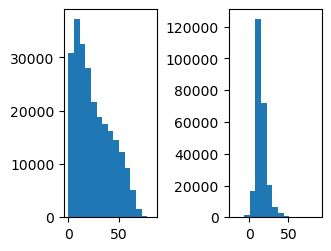

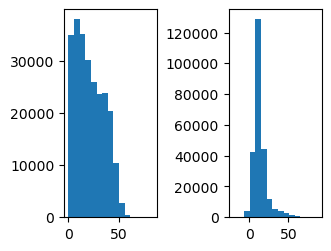

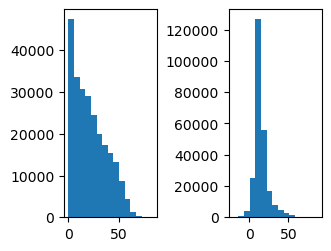

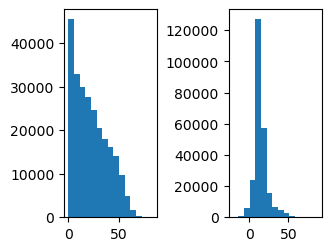

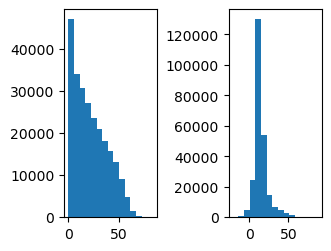

In [11]:
# pfull = ds_tiedtke.pfull.values * munits.pascal
# ta = ds_tiedtke.ta.values * munits.kelvin

# theta_e = equivalent_potential_temperature(pfull, ta, dewpoints)
# plt.hist(np.array(theta_e).ravel(), bins=50);

def calc_plot_ds(var1, var2, minmax, nbins):
    min_var1, max_var1, min_var2, max_var2 = minmax
    fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(6.4/2,4.8/2))

    var1_vals = np.clip(var1.ravel(), min_var1, max_var1)
    var2_vals = np.clip(var2.ravel(), min_var2, max_var2)
    var1_hist_counts, var1_hist_edges, _ = ax[0].hist(var1.ravel(), bins=nbins, range=(min_var1, max_var1))
    var2_hist_counts, var2_hist_edges, _ = ax[1].hist(var2.ravel(), bins=nbins, range=(min_var2, max_var2))
    
    plt.show()
    return var1_hist_counts, var1_hist_edges, var2_hist_counts, var2_hist_edges
# plt.hist(theta_e.values.ravel(), bins=50);
# plt.hist(theta.values.ravel(), bins=50);

# theta.metpy.units, theta_e.metpy.units
nbins = 15
minmax = [min_prw, max_prw, min_lts, max_lts]
prw_hist_counts_tiedtke, prw_hist_edges_tiedtke, lts_hist_counts_tiedtke, lts_hist_edges_tiedtke = calc_plot_ds(ds_tiedtke.prw.values, lts_tiedtke, minmax, nbins)
prw_hist_counts_ml, prw_hist_edges_ml, lts_hist_counts_ml, lts_hist_edges_ml = calc_plot_ds(ds_ml.prw.values, lts_ml, minmax, nbins)
prw_hist_counts_mix, prw_hist_edges_mix, lts_hist_counts_mix, lts_hist_edges_mix = calc_plot_ds(ds_mix.prw.values, lts_mix, minmax, nbins)
prw_hist_counts_mix2, prw_hist_edges_mix2, lts_hist_counts_mix2, lts_hist_edges_mix2 = calc_plot_ds(ds_mix2.prw.values, lts_mix2, minmax, nbins)
prw_hist_counts_mix3, prw_hist_edges_mix3, lts_hist_counts_mix3, lts_hist_edges_mix3 = calc_plot_ds(ds_mix3.prw.values, lts_mix3, minmax, nbins)

prw_hist_mids_tiedtke = (prw_hist_edges_tiedtke[:-1] + prw_hist_edges_tiedtke[1:])/2
lts_hist_mids_tiedtke = (lts_hist_edges_tiedtke[:-1] + lts_hist_edges_tiedtke[1:])/2
prw_hist_mids_ml = (prw_hist_edges_ml[:-1] + prw_hist_edges_ml[1:])/2
lts_hist_mids_ml = (lts_hist_edges_ml[:-1] + lts_hist_edges_ml[1:])/2
prw_hist_mids_mix = (prw_hist_edges_mix[:-1] + prw_hist_edges_mix[1:])/2
lts_hist_mids_mix = (lts_hist_edges_mix[:-1] + lts_hist_edges_mix[1:])/2
prw_hist_mids_mix2 = (prw_hist_edges_mix2[:-1] + prw_hist_edges_mix2[1:])/2
lts_hist_mids_mix2 = (lts_hist_edges_mix2[:-1] + lts_hist_edges_mix2[1:])/2
prw_hist_mids_mix3 = (prw_hist_edges_mix3[:-1] + prw_hist_edges_mix3[1:])/2
lts_hist_mids_mix3 = (lts_hist_edges_mix3[:-1] + lts_hist_edges_mix3[1:])/2

In [12]:
def get_precip_per_bin(precip, binvar, bin_edges):
    result = np.empty(len(bin_edges)-1)
    for i,(le,he) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        mask = (binvar >= le) & (binvar <= he)
        # print(mask.sum())
        result[i] = np.mean(precip[mask])

    return result

# precip_var = 'prcs'

tiedtke_precip = ds_tiedtke['prcr'] + ds_tiedtke['prcs']
ml_precip = ds_ml['prcr'] + ds_ml['prcs']
mix_precip = ds_mix['prcr'] + ds_mix['prcs']
mix2_precip = ds_mix2['prcr'] + ds_mix2['prcs']
mix3_precip = ds_mix3['prcr'] + ds_mix3['prcs']

prcr_prw_tiedtke = get_precip_per_bin(tiedtke_precip.values.ravel(), ds_tiedtke.prw.values.ravel(), prw_hist_edges_tiedtke)
prcr_lts_tiedtke = get_precip_per_bin(tiedtke_precip.values.ravel(), lts_tiedtke.ravel(), lts_hist_edges_tiedtke)

prcr_prw_ml = get_precip_per_bin(ml_precip.values.ravel(), ds_ml.prw.values.ravel(), prw_hist_edges_ml)
prcr_lts_ml = get_precip_per_bin(ml_precip.values.ravel(), lts_ml.ravel(), lts_hist_edges_ml)

prcr_prw_mix = get_precip_per_bin(mix_precip.values.ravel(), ds_mix.prw.values.ravel(), prw_hist_edges_mix)
prcr_lts_mix = get_precip_per_bin(mix_precip.values.ravel(), lts_mix.ravel(), lts_hist_edges_mix)
# Also get ml_weight
prw_mlweight_mix = get_precip_per_bin(ds_mix.extra_2d5.values.ravel(), ds_mix.prw.values.ravel(), prw_hist_edges_mix)
lts_mlweight_mix = get_precip_per_bin(ds_mix.extra_2d5.values.ravel(), lts_mix.ravel(), lts_hist_edges_mix)

prcr_prw_mix2 = get_precip_per_bin(mix2_precip.values.ravel(), ds_mix2.prw.values.ravel(), prw_hist_edges_mix2)
prcr_lts_mix2 = get_precip_per_bin(mix2_precip.values.ravel(), lts_mix2.ravel(), lts_hist_edges_mix2)
# Also get ml_weight
prw_mlweight_mix2 = get_precip_per_bin(ds_mix2.extra_2d5.values.ravel(), ds_mix2.prw.values.ravel(), prw_hist_edges_mix2)
lts_mlweight_mix2 = get_precip_per_bin(ds_mix2.extra_2d5.values.ravel(), lts_mix2.ravel(), lts_hist_edges_mix2)

prcr_prw_mix3 = get_precip_per_bin(mix3_precip.values.ravel(), ds_mix3.prw.values.ravel(), prw_hist_edges_mix3)
prcr_lts_mix3 = get_precip_per_bin(mix3_precip.values.ravel(), lts_mix3.ravel(), lts_hist_edges_mix3)
# # Also get ml_weight
prw_mlweight_mix3 = get_precip_per_bin(ds_mix3.extra_2d5.values.ravel(), ds_mix3.prw.values.ravel(), prw_hist_edges_mix3)
lts_mlweight_mix3 = get_precip_per_bin(ds_mix3.extra_2d5.values.ravel(), lts_mix3.ravel(), lts_hist_edges_mix3)

/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


# For lat,zsfc Dependence

In [13]:
mask = np.s_[:]#land_frac.values > 0.5

clat = clat[mask]
zsfc = zsfc[mask]
tiedtke_precip = tiedtke_precip[:,mask]
ml_precip = ml_precip[:,mask]
mix_precip = mix_precip[:,mask]
mix2_precip = mix2_precip[:,mask]
mix3_precip = mix3_precip[:,mask]

In [14]:
clat = np.abs(clat)

In [15]:
min_zsfc = np.min(zsfc.values)
max_zsfc = np.max(zsfc.values)
min_lat = np.min(clat.values)
max_lat = np.max(clat.values)
# min_zsfc = myround(min_zsfc, base=1)
# max_zsfc = myround(max_zsfc, base=1)
# min_lat = myround(min_lat, base=1)
# max_lat = myround(max_lat, base=1)
min_zsfc, max_zsfc, min_lat, max_lat

(-28.0, 5326.0576, 0.0077551277, 1.551064)

In [16]:
clat.shape

(20480,)

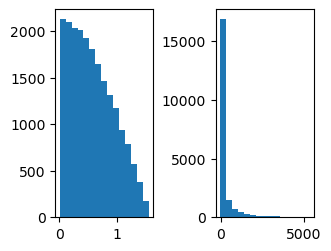

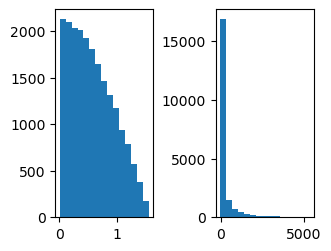

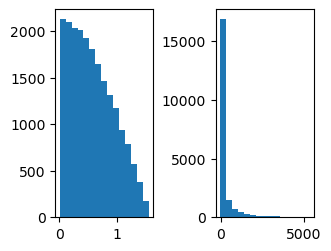

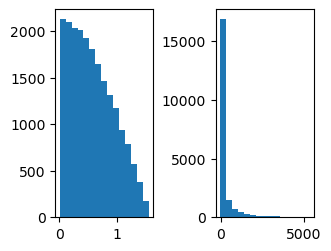

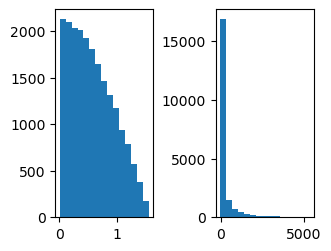

In [17]:
nbins = 15
minmax = [min_lat, max_lat, min_zsfc, max_zsfc]
clat_hist_counts_tiedtke, clat_hist_edges_tiedtke, zsfc_hist_counts_tiedtke, zsfc_hist_edges_tiedtke = calc_plot_ds(clat.values, zsfc.values, minmax, nbins)
clat_hist_counts_ml, clat_hist_edges_ml, zsfc_hist_counts_ml, zsfc_hist_edges_ml = calc_plot_ds(clat.values, zsfc.values, minmax, nbins)
clat_hist_counts_mix, clat_hist_edges_mix, zsfc_hist_counts_mix, zsfc_hist_edges_mix = calc_plot_ds(clat.values, zsfc.values, minmax, nbins)
clat_hist_counts_mix2, clat_hist_edges_mix2, zsfc_hist_counts_mix2, zsfc_hist_edges_mix2 = calc_plot_ds(clat.values, zsfc.values, minmax, nbins)
clat_hist_counts_mix3, clat_hist_edges_mix3, zsfc_hist_counts_mix3, zsfc_hist_edges_mix3 = calc_plot_ds(clat.values, zsfc.values, minmax, nbins)

clat_hist_mids_tiedtke = (clat_hist_edges_tiedtke[:-1] + clat_hist_edges_tiedtke[1:])/2
zsfc_hist_mids_tiedtke = (zsfc_hist_edges_tiedtke[:-1] + zsfc_hist_edges_tiedtke[1:])/2
clat_hist_mids_ml = (clat_hist_edges_ml[:-1] + clat_hist_edges_ml[1:])/2
zsfc_hist_mids_ml = (zsfc_hist_edges_ml[:-1] + zsfc_hist_edges_ml[1:])/2
clat_hist_mids_mix = (clat_hist_edges_mix[:-1] + clat_hist_edges_mix[1:])/2
zsfc_hist_mids_mix = (zsfc_hist_edges_mix[:-1] + zsfc_hist_edges_mix[1:])/2
clat_hist_mids_mix2 = (clat_hist_edges_mix2[:-1] + clat_hist_edges_mix2[1:])/2
zsfc_hist_mids_mix2 = (zsfc_hist_edges_mix2[:-1] + zsfc_hist_edges_mix2[1:])/2
clat_hist_mids_mix3 = (clat_hist_edges_mix3[:-1] + clat_hist_edges_mix3[1:])/2
zsfc_hist_mids_mix3 = (zsfc_hist_edges_mix3[:-1] + zsfc_hist_edges_mix3[1:])/2

In [18]:
prcr_clat_tiedtke = get_precip_per_bin(tiedtke_precip.values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_tiedtke)
prcr_zsfc_tiedtke = get_precip_per_bin(tiedtke_precip.values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_tiedtke)

prcr_clat_ml = get_precip_per_bin(ml_precip.values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_ml)
prcr_zsfc_ml = get_precip_per_bin(ml_precip.values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_ml)

prcr_clat_mix = get_precip_per_bin(mix_precip.values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix)
prcr_zsfc_mix = get_precip_per_bin(mix_precip.values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix)
# Also get ml_weight
clat_mlweight_mix = get_precip_per_bin(ds_mix.extra_2d5.values[:,mask].ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix)
zsfc_mlweight_mix = get_precip_per_bin(ds_mix.extra_2d5.values[:,mask].ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix)

prcr_clat_mix2 = get_precip_per_bin(mix2_precip.values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix2)
prcr_zsfc_mix2 = get_precip_per_bin(mix2_precip.values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix2)
# Also get ml_weight
clat_mlweight_mix2 = get_precip_per_bin(ds_mix2.extra_2d5[:,mask].values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix2)
zsfc_mlweight_mix2 = get_precip_per_bin(ds_mix2.extra_2d5[:,mask].values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix2)

prcr_clat_mix3 = get_precip_per_bin(mix3_precip.values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix3)
prcr_zsfc_mix3 = get_precip_per_bin(mix3_precip.values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix3)
# # Also get ml_weight
clat_mlweight_mix3 = get_precip_per_bin(ds_mix3.extra_2d5[:,mask].values.ravel(), np.tile(clat.values, (12,1)).ravel(), clat_hist_edges_mix3)
zsfc_mlweight_mix3 = get_precip_per_bin(ds_mix3.extra_2d5[:,mask].values.ravel(), np.tile(zsfc.values, (12,1)).ravel(), zsfc_hist_edges_mix3)

clat_hist_counts_tiedtke *= 12
zsfc_hist_counts_tiedtke *= 12
clat_hist_counts_ml *= 12
zsfc_hist_counts_ml *= 12
clat_hist_counts_mix *= 12
zsfc_hist_counts_mix *= 12
clat_hist_counts_mix2 *= 12
zsfc_hist_counts_mix2 *= 12
clat_hist_counts_mix3 *= 12
zsfc_hist_counts_mix3 *= 12

In [19]:
import matplotlib as mpl
from cycler import cycler

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# mpl.rcParams['axes.prop_cycle'] = cycler(color=CB_color_cycle)
# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk') # default

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [20]:
# # Old version

# setup_mpl_tex()

# fig, ax = plt.subplots(1,2,
#                        constrained_layout=True,
#                        figsize=(6.4*1,3.4),
#                       )

# s_div = 500
# # todo: change for abslat - zfsc plot
# ax0_xscale = 1#180/np.pi
# ax1_xscale = 1#1/1000
# ax[0].scatter(prw_hist_mids_tiedtke*ax0_xscale, prcr_prw_tiedtke, s=prw_hist_counts_tiedtke/s_div, color=CB_color_cycle[0], label='Tiedtke')
# ax[1].scatter(lts_hist_mids_tiedtke*ax1_xscale, prcr_lts_tiedtke, s=lts_hist_counts_tiedtke/s_div, color=CB_color_cycle[0])
# ax[0].scatter(prw_hist_mids_ml*ax0_xscale, prcr_prw_ml,s=prw_hist_counts_ml/s_div, color=CB_color_cycle[1], label='Pure ML')
# ax[1].scatter(lts_hist_mids_ml*ax1_xscale, prcr_lts_ml,s=lts_hist_counts_ml/s_div, color=CB_color_cycle[1])
# ax[0].scatter(prw_hist_mids_mix*ax0_xscale, prcr_prw_mix, s=prw_hist_counts_mix/s_div, color=CB_color_cycle[2], label=label_mix1)
# ax[1].scatter(lts_hist_mids_mix*ax1_xscale, prcr_lts_mix, s=lts_hist_counts_mix/s_div, color=CB_color_cycle[2])
# ax[0].scatter(prw_hist_mids_mix2*ax0_xscale, prcr_prw_mix2, s=prw_hist_counts_mix2/s_div, color=CB_color_cycle[3], label=label_mix2)
# ax[1].scatter(lts_hist_mids_mix2*ax1_xscale, prcr_lts_mix2, s=lts_hist_counts_mix2/s_div, color=CB_color_cycle[3])
# ax[0].scatter(prw_hist_mids_mix3*ax0_xscale, prcr_prw_mix3, s=prw_hist_counts_mix3/s_div, color=CB_color_cycle[4], label=label_mix3)
# ax[1].scatter(lts_hist_mids_mix3*ax1_xscale, prcr_lts_mix3, s=lts_hist_counts_mix3/s_div, color=CB_color_cycle[4])
# ax[0].plot(prw_hist_mids_tiedtke*ax0_xscale, prcr_prw_tiedtke, ls='--', color=CB_color_cycle[0])
# ax[1].plot(lts_hist_mids_tiedtke*ax1_xscale, prcr_lts_tiedtke, ls='--', color=CB_color_cycle[0])
# ax[0].plot(prw_hist_mids_ml*ax0_xscale, prcr_prw_ml, ls='--', color=CB_color_cycle[1])
# ax[1].plot(lts_hist_mids_ml*ax1_xscale, prcr_lts_ml, ls='--', color=CB_color_cycle[1])
# ax[0].plot(prw_hist_mids_mix*ax0_xscale, prcr_prw_mix, ls='--', color=CB_color_cycle[2])
# ax[1].plot(lts_hist_mids_mix*ax1_xscale, prcr_lts_mix, ls='--', color=CB_color_cycle[2])
# ax[0].plot(prw_hist_mids_mix2*ax0_xscale, prcr_prw_mix2, ls='--', color=CB_color_cycle[3])
# ax[1].plot(lts_hist_mids_mix2*ax1_xscale, prcr_lts_mix2, ls='--', color=CB_color_cycle[3])
# ax[0].plot(prw_hist_mids_mix3*ax0_xscale, prcr_prw_mix3, ls='--', color=CB_color_cycle[4])
# ax[1].plot(lts_hist_mids_mix3*ax1_xscale, prcr_lts_mix3, ls='--', color=CB_color_cycle[4])
# ax0_2 = ax[0].twinx()
# ax1_2 = ax[1].twinx()

# ax0_2.plot(prw_hist_mids_mix*ax0_xscale, prw_mlweight_mix, ':x', ms=5, label=f'{label_mix1} - $\lambda$', color=CB_color_cycle[2])#'1ec74b')
# ax1_2.plot(lts_hist_mids_mix*ax1_xscale, lts_mlweight_mix, ':x', ms=5, color=CB_color_cycle[2])#'1ec74b')
# ax0_2.plot(prw_hist_mids_mix2*ax0_xscale, prw_mlweight_mix2, ':x', ms=5, label=f'{label_mix2} - $\lambda$', color=CB_color_cycle[3])#'f53b31')
# ax1_2.plot(lts_hist_mids_mix2*ax1_xscale, lts_mlweight_mix2, ':x', ms=5, color=CB_color_cycle[3])#'#f53b31')
# ax0_2.plot(prw_hist_mids_mix3*ax0_xscale, prw_mlweight_mix3, ':x', ms=5, label=f'{label_mix3} - $\lambda$', color=CB_color_cycle[4])#'#bb4de3')
# ax1_2.plot(lts_hist_mids_mix3*ax1_xscale, lts_mlweight_mix3, ':x', ms=5, color=CB_color_cycle[4])#'#bb4de3')
# ax0_2.set_ylim(0,1.1)
# ax1_2.set_ylim(0,1.1)
# align_yaxis(ax[0], 0, ax0_2, 0)
# align_yaxis(ax[1], 0, ax1_2, 0)
# # ax0_2.set_ylim(0.5,1)
# # ax1_2.set_ylim(0.5,1)
# # ax[1].set_ylim(2e-7,7e-5)
# ax[0].set_ylim(1e-6,None)

# ax[0].set_xlabel(prw_label)
# ax[1].set_xlabel('LTS (K)')
# # todo: change for abslat - zfsc plot
# # ax[0].set_xlabel('Absolute Latitude (°)')
# # ax[1].set_xlabel('Surface Height (km)')
# ax[0].set_ylabel('Convective Precipitation (kg m-2 s-1)')
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# # ax[0].set_ylim(ax[1].get_ylim())
# # ax0_2.tick_params(axis='y', colors='#1ec74b')
# # ax1_2.tick_params(axis='y', colors='#1ec74b')

# ax1_2.set_ylabel('$\\langle\\lambda\\rangle$')#, color='#1ec74b')

# ax[0].set_title('a)', x=-0.05)
# ax[1].set_title('b)', x=-0.05)
# ax[0].grid()
# ax[1].grid()
# # ax[0].text(0.0, 1.0, 'a)', transform=(ax[0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_xscale_trans)), fontsize='large', va='bottom', fontfamily='serif')
# # ax[1].text(0.0, 1.0, 'b)', transform=(ax[1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)), fontsize='large', va='bottom', fontfamily='serif')

# # ax[0].legend()
# handles = []
# labels = []
# for figax in fig.get_axes():
#     axhandles, axlabels = figax.get_legend_handles_labels()   
#     handles.extend(axhandles)
#     labels.extend(axlabels)

# # order = [0,2,3,4,1,5,6,7]
# order = [0,1,2,5,4,7,3,6]
# # plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
# fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.), loc="upper center", ncol=4)

# # fig.savefig('Figures/Precipitation_PRW_LTS-theta_5models_log.pdf', bbox_inches='tight')#, dpi=300)
# # todo: change for abslat - zfsc plot
# # fig.savefig('Figures/Precipitation_abslat_zfsc_5models_log.pdf', bbox_inches='tight')#, dpi=300)

# plt.show()

In [21]:
sum(prw_hist_counts_tiedtke), sum(lts_hist_counts_tiedtke), sum(clat_hist_counts_tiedtke)

(245760.0, 245760.0, 245760.0)

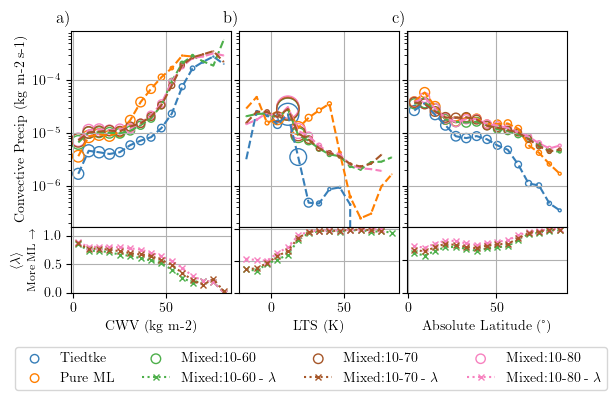

In [22]:
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import FuncFormatter
from setup_mpl_tex import setup_mpl_tex, set_size
from matplotlib import gridspec

setup_mpl_tex()

# # figsize = set_size('textwidth')
# fig, ax = plt.subplots(2,2,
#                        # constrained_layout=True,
#                        figsize=(6.4*1,3.4),
#                        gridspec_kw=dict(hspace=0),
#                        # sharex=True
#                       )

fig = plt.figure(figsize=(6.4,3.4))
gs = gridspec.GridSpec(4, 3, hspace=0, wspace=0.05, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0:3,0]))
axlist.append(fig.add_subplot(gs[0:3,1], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[0:3,2], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[3,0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[3,1], sharex=axlist[1]))
axlist.append(fig.add_subplot(gs[3,2], sharex=axlist[2]))
# axlist.append(fig.add_subplot(gs[0,0]))
# axlist.append(fig.add_subplot(gs[0,1]))
# axlist.append(fig.add_subplot(gs[1,0]))
# axlist.append(fig.add_subplot(gs[1,1]))
ax = np.array(axlist).reshape(2,3)

s_div = 500
size_transform = lambda s: s/500 #np.minimum(s/500, 50) #np.log(s+0.001)*2#
# todo: change for abslat - zfsc plot
ax0_xscale = 1#180/np.pi
ax1_xscale = 1#1/1000
ax[0,0].scatter(prw_hist_mids_tiedtke*ax0_xscale, prcr_prw_tiedtke, s=size_transform(prw_hist_counts_tiedtke), color=CB_color_cycle[0], label='Tiedtke', facecolors='none')
ax[0,1].scatter(lts_hist_mids_tiedtke*ax1_xscale, prcr_lts_tiedtke, s=size_transform(lts_hist_counts_tiedtke), color=CB_color_cycle[0], facecolors='none')
ax[0,2].scatter(clat_hist_mids_tiedtke*180/np.pi, prcr_clat_tiedtke, s=size_transform(clat_hist_counts_tiedtke), color=CB_color_cycle[0], facecolors='none')
ax[0,0].scatter(prw_hist_mids_ml*ax0_xscale, prcr_prw_ml,s=size_transform(prw_hist_counts_ml), color=CB_color_cycle[1], label='Pure ML', facecolors='none')
ax[0,1].scatter(lts_hist_mids_ml*ax1_xscale, prcr_lts_ml,s=size_transform(lts_hist_counts_ml), color=CB_color_cycle[1], facecolors='none')
ax[0,2].scatter(clat_hist_mids_ml*180/np.pi, prcr_clat_ml,s=size_transform(clat_hist_counts_ml), color=CB_color_cycle[1], facecolors='none')
ax[0,0].scatter(prw_hist_mids_mix*ax0_xscale, prcr_prw_mix, s=size_transform(prw_hist_counts_mix), color=CB_color_cycle[2], label=label_mix1, facecolors='none')
ax[0,1].scatter(lts_hist_mids_mix*ax1_xscale, prcr_lts_mix, s=size_transform(lts_hist_counts_mix), color=CB_color_cycle[2], facecolors='none')
ax[0,2].scatter(clat_hist_mids_mix*180/np.pi, prcr_clat_mix, s=size_transform(clat_hist_counts_mix), color=CB_color_cycle[2], facecolors='none')
ax[0,0].scatter(prw_hist_mids_mix2*ax0_xscale, prcr_prw_mix2, s=size_transform(prw_hist_counts_mix2), color=CB_color_cycle[3], label=label_mix2, facecolors='none')
ax[0,1].scatter(lts_hist_mids_mix2*ax1_xscale, prcr_lts_mix2, s=size_transform(lts_hist_counts_mix2), color=CB_color_cycle[3], facecolors='none')
ax[0,2].scatter(clat_hist_mids_mix2*180/np.pi, prcr_clat_mix2, s=size_transform(clat_hist_counts_mix2), color=CB_color_cycle[3], facecolors='none')
ax[0,0].scatter(prw_hist_mids_mix3*ax0_xscale, prcr_prw_mix3, s=size_transform(prw_hist_counts_mix3), color=CB_color_cycle[4], label=label_mix3, facecolors='none')
ax[0,1].scatter(lts_hist_mids_mix3*ax1_xscale, prcr_lts_mix3, s=size_transform(lts_hist_counts_mix3), color=CB_color_cycle[4], facecolors='none')
ax[0,2].scatter(clat_hist_mids_mix3*180/np.pi, prcr_clat_mix3, s=size_transform(clat_hist_counts_mix3), color=CB_color_cycle[4], facecolors='none')
ax[0,0].plot(prw_hist_mids_tiedtke*ax0_xscale, prcr_prw_tiedtke, ls='--', color=CB_color_cycle[0])
ax[0,1].plot(lts_hist_mids_tiedtke*ax1_xscale, prcr_lts_tiedtke, ls='--', color=CB_color_cycle[0])
ax[0,2].plot(clat_hist_mids_tiedtke*180/np.pi, prcr_clat_tiedtke, ls='--', color=CB_color_cycle[0])
ax[0,0].plot(prw_hist_mids_ml*ax0_xscale, prcr_prw_ml, ls='--', color=CB_color_cycle[1])
ax[0,1].plot(lts_hist_mids_ml*ax1_xscale, prcr_lts_ml, ls='--', color=CB_color_cycle[1])
ax[0,2].plot(clat_hist_mids_ml*180/np.pi, prcr_clat_ml, ls='--', color=CB_color_cycle[1])
ax[0,0].plot(prw_hist_mids_mix*ax0_xscale, prcr_prw_mix, ls='--', color=CB_color_cycle[2])
ax[0,1].plot(lts_hist_mids_mix*ax1_xscale, prcr_lts_mix, ls='--', color=CB_color_cycle[2])
ax[0,2].plot(clat_hist_mids_mix*180/np.pi, prcr_clat_mix, ls='--', color=CB_color_cycle[2])
ax[0,0].plot(prw_hist_mids_mix2*ax0_xscale, prcr_prw_mix2, ls='--', color=CB_color_cycle[3])
ax[0,1].plot(lts_hist_mids_mix2*ax1_xscale, prcr_lts_mix2, ls='--', color=CB_color_cycle[3])
ax[0,2].plot(clat_hist_mids_mix2*180/np.pi, prcr_clat_mix2, ls='--', color=CB_color_cycle[3])
ax[0,0].plot(prw_hist_mids_mix3*ax0_xscale, prcr_prw_mix3, ls='--', color=CB_color_cycle[4])
ax[0,1].plot(lts_hist_mids_mix3*ax1_xscale, prcr_lts_mix3, ls='--', color=CB_color_cycle[4])
ax[0,2].plot(clat_hist_mids_mix3*180/np.pi, prcr_clat_mix3, ls='--', color=CB_color_cycle[4])

ax[1,0].plot(prw_hist_mids_mix*ax0_xscale, prw_mlweight_mix, ':x', ms=5, label=f'{label_mix1} - $\lambda$', color=CB_color_cycle[2])#'1ec74b')
ax[1,1].plot(lts_hist_mids_mix*ax1_xscale, lts_mlweight_mix, ':x', ms=5, color=CB_color_cycle[2])#'1ec74b')
ax[1,2].plot(clat_hist_mids_mix*180/np.pi, clat_mlweight_mix, ':x', ms=5, color=CB_color_cycle[2])#'1ec74b')
ax[1,0].plot(prw_hist_mids_mix2*ax0_xscale, prw_mlweight_mix2, ':x', ms=5, label=f'{label_mix2} - $\lambda$', color=CB_color_cycle[3])#'f53b31')
ax[1,1].plot(lts_hist_mids_mix2*ax1_xscale, lts_mlweight_mix2, ':x', ms=5, color=CB_color_cycle[3])#'#f53b31')
ax[1,2].plot(clat_hist_mids_mix2*180/np.pi, clat_mlweight_mix2, ':x', ms=5, color=CB_color_cycle[3])#'#f53b31')
ax[1,0].plot(prw_hist_mids_mix3*ax0_xscale, prw_mlweight_mix3, ':x', ms=5, label=f'{label_mix3} - $\lambda$', color=CB_color_cycle[4])#'#bb4de3')
ax[1,1].plot(lts_hist_mids_mix3*ax1_xscale, lts_mlweight_mix3, ':x', ms=5, color=CB_color_cycle[4])#'#bb4de3')
ax[1,2].plot(clat_hist_mids_mix3*180/np.pi, clat_mlweight_mix3, ':x', ms=5, color=CB_color_cycle[4])#'#bb4de3')
ax[1,0].set_ylim(0,1.15)
# align_yaxis(ax[0,0], 0, ax[0,1], 0)
# align_yaxis(ax[0,1], 0, ax[1,1], 0)
# ax[0,1].set_ylim(0.5,1)
# ax[1,1].set_ylim(0.5,1)
# ax[0,1].set_ylim(2e-7,7e-5)
# ax[0,0].set_ylim(1e-6,None)
# ax[0,1].set_ylim(ax[0,0].get_ylim())

ax[1,0].set_xlabel(prw_label)
ax[1,1].set_xlabel('LTS (K)')
ax[1,2].set_xlabel('Absolute Latitude (°)')
# ax[1,1].set_xlabel('Surface Height (km)')
ax[0,0].set_ylabel('Convective Precip (kg m-2 s-1)')
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log')
# ax[0,0].set_ylim(ax[0,1].get_ylim())
# ax[0,1].tick_params(axis='y', colors='#1ec74b')
# ax[1,1].tick_params(axis='y', colors='#1ec74b')

# ax[1,0].set_ylabel('$\\langle\\lambda\\rangle$')#, color='#1ec74b')
# ax[1,0].set_ylabel('$\\langle\\lambda\\rangle$\nMore ML →')
ax[1,0].set_ylabel('$\\langle\\lambda\\rangle$\n{\\footnotesize More ML →}')

ax[0,0].set_title('a)', x=-0.05)
ax[0,1].set_title('b)', x=-0.05)
ax[0,2].set_title('c)', x=-0.05)
# ax[0,0].text(0.0, 1.0, 'a)', transform=(ax[0,0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_xscale_trans)), fontsize='large', va='bottom', fontfamily='serif')
# ax[0,1].text(0.0, 1.0, 'b)', transform=(ax[0,1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)), fontsize='large', va='bottom', fontfamily='serif')

# ax[0,0].legend()
handles = []
labels = []
for figax in fig.get_axes():
    figax.grid()
    axhandles, axlabels = figax.get_legend_handles_labels()   
    handles.extend(axhandles)
    labels.extend(axlabels)

# order = [0,2,3,4,1,5,6,7]
order = [0,1,2,5,4,7,3,6]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.03), loc="upper center", ncol=4)

for i in range(3):
    ax[0,i].tick_params(labelbottom=False)
    ax[1,i].set_yticks([0,0.5,1])

ax[0,1].tick_params(labelleft=False)
ax[0,2].tick_params(labelleft=False)
ax[1,1].tick_params(labelleft=False)
ax[1,2].tick_params(labelleft=False)

# # Add performance direction indicator at the side
# ax[1,2].annotate(
#     'More ML →',
#     size='small',
#     xy=(1.02, 0.5),        # position in axes coords
#     xycoords='axes fraction',
#     rotation=90,           # vertical text
#     va='center'
# )

# fig.savefig('Figures/Precipitation_PRW_LTS_abslat-theta_5models_log.pdf', bbox_inches='tight')#, dpi=300)

plt.show()

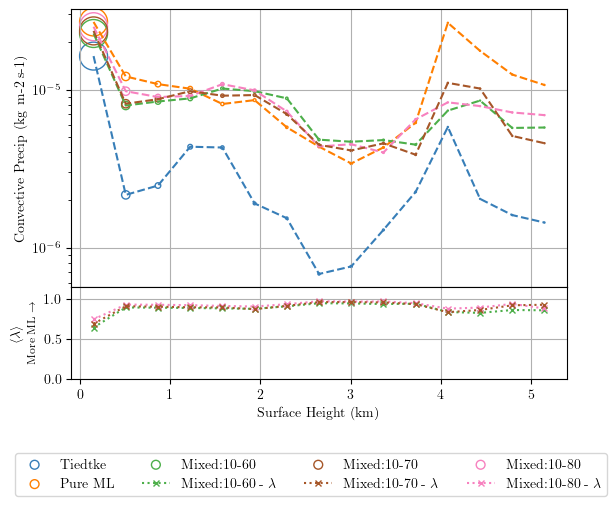

In [37]:
from matplotlib.transforms import ScaledTranslation
from matplotlib.ticker import FuncFormatter
from setup_mpl_tex import setup_mpl_tex, set_size
from matplotlib import gridspec

setup_mpl_tex()

# # figsize = set_size('textwidth')
# fig, ax = plt.subplots(1,1,
#                        constrained_layout=True,
#                        figsize=(6.4*1,3.4),
#                        # gridspec_kw=dict(hspace=0),
#                        # sharex=True
#                       )
fig = plt.figure(figsize=(6.4,4.8))
gs = gridspec.GridSpec(4, 1, hspace=0, wspace=0.05, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0:3,0]))
axlist.append(fig.add_subplot(gs[3,0], sharex=axlist[0]))
# axlist.append(fig.add_subplot(gs[0,0]))
# axlist.append(fig.add_subplot(gs[0,1]))
# axlist.append(fig.add_subplot(gs[1,0]))
# axlist.append(fig.add_subplot(gs[1,1]))
ax = np.array(axlist).reshape(2,1)

# todo: change for abslat - zfsc plot
ax0_xscale = 1/1000
ax[0,0].scatter(zsfc_hist_mids_tiedtke*ax0_xscale, prcr_zsfc_tiedtke, s=size_transform(zsfc_hist_counts_tiedtke), color=CB_color_cycle[0], label='Tiedtke', facecolors='none')
ax[0,0].scatter(zsfc_hist_mids_ml*ax0_xscale, prcr_zsfc_ml,s=size_transform(zsfc_hist_counts_ml), color=CB_color_cycle[1], label='Pure ML', facecolors='none')
ax[0,0].scatter(zsfc_hist_mids_mix*ax0_xscale, prcr_zsfc_mix, s=size_transform(zsfc_hist_counts_mix), color=CB_color_cycle[2], label=label_mix1, facecolors='none')
ax[0,0].scatter(zsfc_hist_mids_mix2*ax0_xscale, prcr_zsfc_mix2, s=size_transform(zsfc_hist_counts_mix2), color=CB_color_cycle[3], label=label_mix2, facecolors='none')
ax[0,0].scatter(zsfc_hist_mids_mix3*ax0_xscale, prcr_zsfc_mix3, s=size_transform(zsfc_hist_counts_mix3), color=CB_color_cycle[4], label=label_mix3, facecolors='none')
ax[0,0].plot(zsfc_hist_mids_tiedtke*ax0_xscale, prcr_zsfc_tiedtke, ls='--', color=CB_color_cycle[0])
ax[0,0].plot(zsfc_hist_mids_ml*ax0_xscale, prcr_zsfc_ml, ls='--', color=CB_color_cycle[1])
ax[0,0].plot(zsfc_hist_mids_mix*ax0_xscale, prcr_zsfc_mix, ls='--', color=CB_color_cycle[2])
ax[0,0].plot(zsfc_hist_mids_mix2*ax0_xscale, prcr_zsfc_mix2, ls='--', color=CB_color_cycle[3])
ax[0,0].plot(zsfc_hist_mids_mix3*ax0_xscale, prcr_zsfc_mix3, ls='--', color=CB_color_cycle[4])

ax[1,0].plot(zsfc_hist_mids_mix*ax0_xscale, zsfc_mlweight_mix, ':x', ms=5, label=f'{label_mix1} - $\lambda$', color=CB_color_cycle[2])#'1ec74b')
ax[1,0].plot(zsfc_hist_mids_mix2*ax0_xscale, zsfc_mlweight_mix2, ':x', ms=5, label=f'{label_mix2} - $\lambda$', color=CB_color_cycle[3])#'f53b31')
ax[1,0].plot(zsfc_hist_mids_mix3*ax0_xscale, zsfc_mlweight_mix3, ':x', ms=5, label=f'{label_mix3} - $\lambda$', color=CB_color_cycle[4])#'#bb4de3')
ax[1,0].set_ylim(0,1.15)
# align_yaxis(ax[0,0], 0, ax[0,1], 0)
# align_yaxis(ax[0,1], 0, ax[1,1], 0)
# ax[0,1].set_ylim(0.5,1)
# ax[1,1].set_ylim(0.5,1)
# ax[0,1].set_ylim(2e-7,7e-5)
# ax[0,0].set_ylim(1e-6,None)
# ax[0,1].set_ylim(ax[0,0].get_ylim())

ax[1,0].set_xlabel('Surface Height (km)')
ax[0,0].set_ylabel('Convective Precip (kg m-2 s-1)')
ax[0,0].set_yscale('log')
# ax[0,0].set_ylim(ax[0,1].get_ylim())
# ax[0,1].tick_params(axis='y', colors='#1ec74b')
# ax[1,1].tick_params(axis='y', colors='#1ec74b')

# ax[1,0].set_ylabel('$\\langle\\lambda\\rangle$')#, color='#1ec74b')
ax[1,0].set_ylabel('$\\langle\\lambda\\rangle$\n{\\footnotesize More ML →}')

# ax[0,0].set_title('a)', x=-0.05)
# ax[0,1].set_title('b)', x=-0.05)
# ax[0,2].set_title('c)', x=-0.05)
# ax[0,0].text(0.0, 1.0, 'a)', transform=(ax[0,0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_xscale_trans)), fontsize='large', va='bottom', fontfamily='serif')
# ax[0,1].text(0.0, 1.0, 'b)', transform=(ax[0,1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)), fontsize='large', va='bottom', fontfamily='serif')

# ax[0,0].legend()
handles = []
labels = []
for figax in fig.get_axes():
    figax.grid()
    axhandles, axlabels = figax.get_legend_handles_labels()   
    handles.extend(axhandles)
    labels.extend(axlabels)

# order = [0,2,3,4,1,5,6,7]
order = [0,1,2,5,4,7,3,6]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
lgnd = fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.03), loc="upper center", ncol=4)

for handle in lgnd.legend_handles:
    if isinstance(handle, mpl.collections.PathCollection):
        handle._sizes *= 0.2

ax[0,0].tick_params(labelbottom=False)
ax[1,0].set_yticks([0,0.5,1])

# fig.savefig('Figures/Precipitation_zsfc-theta_5models_log.pdf', bbox_inches='tight')#, dpi=300)

plt.show()

# 2d

In [24]:
def get_precip_per_bin2d(precip, binvar1, binvar2, bin_edges1, bin_edges2):
    result = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
    counts = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
    for i,(le1,he1) in enumerate(zip(bin_edges1[:-1], bin_edges1[1:])):
        for j,(le2,he2) in enumerate(zip(bin_edges2[:-1], bin_edges2[1:])):
            mask = (binvar1 >= le1) & (binvar1 <= he1) & (binvar2 >= le2) & (binvar2 <= he2)
            counts[i,j] = mask.sum()
            # if i == 4:
            #     result[i,j] = 1e-5
            # else:
            result[i,j] = np.mean(precip[mask])
            # result[i,j] = i
            # result[i,j] = i+j

    counts[counts==0] = np.nan
    return result[:,:], counts
    
prcr_tiedtke2d_bins, prcr_tiedtke2d_counts = get_precip_per_bin2d(tiedtke_precip.values.ravel(),
                                           ds_tiedtke.prw.values.ravel(), lts_tiedtke.ravel(),
                                           prw_hist_edges_tiedtke, lts_hist_edges_tiedtke)

prcr_ml2d_bins, prcr_ml2d_counts = get_precip_per_bin2d(ml_precip.values.ravel(),
                                      ds_ml.prw.values.ravel(), lts_ml.ravel(),
                                      prw_hist_edges_ml, lts_hist_edges_ml)

prcr_mix2d_bins, prcr_mix2d_counts = get_precip_per_bin2d(mix_precip.values.ravel(),
                                       ds_mix.prw.values.ravel(), lts_mix.ravel(),
                                       prw_hist_edges_mix, lts_hist_edges_mix)

prcr_mix22d_bins, prcr_mix22d_counts = get_precip_per_bin2d(mix2_precip.values.ravel(),
                                       ds_mix2.prw.values.ravel(), lts_mix2.ravel(),
                                       prw_hist_edges_mix2, lts_hist_edges_mix2)

prcr_mix32d_bins, prcr_mix32d_counts = get_precip_per_bin2d(mix3_precip.values.ravel(),
                                       ds_mix3.prw.values.ravel(), lts_mix3.ravel(),
                                       prw_hist_edges_mix3, lts_hist_edges_mix3)

/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


19.59999942779541


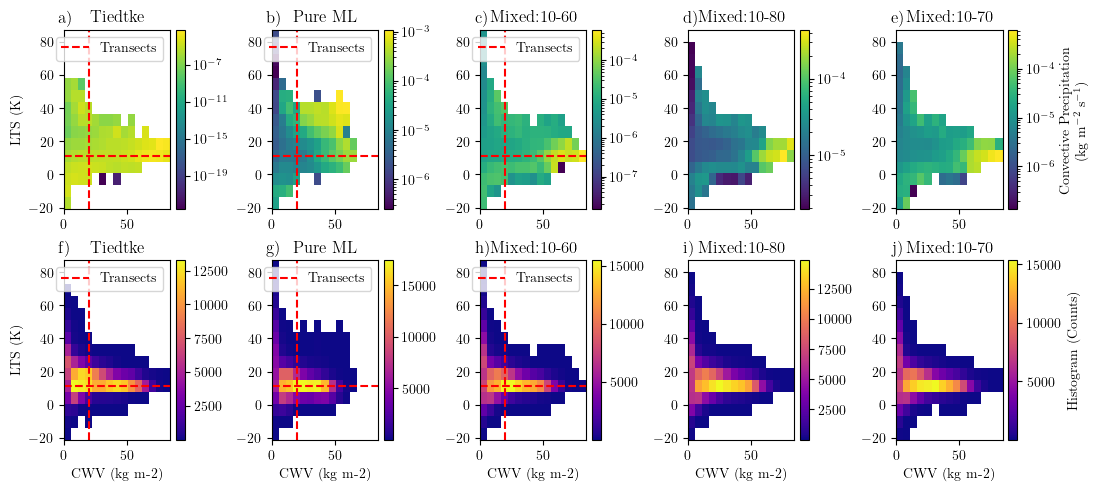

In [25]:
from matplotlib.colors import LogNorm, Normalize
import string

cmap_counts = plt.get_cmap('plasma')

fig, ax = plt.subplots(2,5,constrained_layout=True, figsize=(6.4*1.7,4.8*1))

norm = LogNorm

precip_min = None#min(np.min(tiedtke_precip.values), np.min(ml_precip.values), np.min(mix_precip.values), np.min(mix2_precip.values), np.min(mix3_precip.values)) + 1e-10
precip_max = None#max(np.max(tiedtke_precip.values), np.max(ml_precip.values), np.max(mix_precip.values), np.max(mix2_precip.values), np.max(mix3_precip.values))
transect_idx_prw = 3
transect_idx_lts = 4

fontsize = 'x-small'

p1 = ax[0,0].pcolormesh(prw_hist_mids_tiedtke, lts_hist_mids_tiedtke, prcr_tiedtke2d_bins.T, norm=norm(vmin=precip_min, vmax=precip_max))
cb = fig.colorbar(p1, ax=ax[0,0])
# cb.set_label(label='Convective Precipitation / kg m-2 s-1', fontsize=fontsize)
print(prw_hist_mids_tiedtke[transect_idx_prw])
for axx in ax[:,0]:
    axx.axvline(prw_hist_mids_tiedtke[transect_idx_prw], ls='--', color='red', label='Transects')
    axx.axhline(lts_hist_mids_tiedtke[transect_idx_lts], ls='--', color='red')
    axx.legend()
ax[0,0].set_title('Tiedtke')
ax[1,0].set_title('Tiedtke')
p12 = ax[1,0].pcolormesh(prw_hist_mids_tiedtke, lts_hist_mids_tiedtke, prcr_tiedtke2d_counts.T, cmap=cmap_counts)
cb = fig.colorbar(p12, ax=ax[1,0])
# cb.set_label(label='Histogram (Counts)', fontsize=fontsize)

p2 = ax[0,1].pcolormesh(prw_hist_mids_ml, lts_hist_mids_ml, prcr_ml2d_bins.T, norm=norm(vmin=precip_min, vmax=precip_max))
cb = fig.colorbar(p2, ax=ax[0,1])
# cb.set_label(label='Convective Precipitation / kg m-2 s-1', fontsize=fontsize)
for axx in ax[:,1]:
    axx.axvline(prw_hist_mids_ml[transect_idx_prw], ls='--', color='red', label='Transects')
    axx.axhline(lts_hist_mids_ml[transect_idx_lts], ls='--', color='red')
    axx.legend()
ax[0,1].set_title('Pure ML')
ax[1,1].set_title('Pure ML')
p22 = ax[1,1].pcolormesh(prw_hist_mids_ml, lts_hist_mids_ml, prcr_ml2d_counts.T, cmap=cmap_counts)
cb = fig.colorbar(p22, ax=ax[1,1])
# cb.set_label(label='Histogram (Counts)', fontsize=fontsize)

p3 = ax[0,2].pcolormesh(prw_hist_mids_mix, lts_hist_mids_mix, prcr_mix2d_bins.T, norm=norm(vmin=precip_min, vmax=precip_max))
cb = fig.colorbar(p3, ax=ax[0,2])
# cb.set_label(label='Convective Precipitation / kg m-2 s-1', fontsize=fontsize)
for axx in ax[:,2]:
    axx.axvline(prw_hist_mids_mix[transect_idx_prw], ls='--', color='red', label='Transects')
    axx.axhline(lts_hist_mids_mix[transect_idx_lts], ls='--', color='red')
    axx.legend()
ax[0,2].set_title(label_mix1)
ax[1,2].set_title(label_mix1)
p32 = ax[1,2].pcolormesh(prw_hist_mids_mix, lts_hist_mids_mix, prcr_mix2d_counts.T, cmap=cmap_counts)
cb = fig.colorbar(p32, ax=ax[1,2])
# cb.set_label(label='Histogram (Counts)', fontsize=fontsize)

p4 = ax[0,3].pcolormesh(prw_hist_mids_mix2, lts_hist_mids_mix2, prcr_mix22d_bins.T, norm=norm(vmin=precip_min, vmax=precip_max))
cb = fig.colorbar(p4, ax=ax[0,3])
# cb.set_label(label='Convective Precipitation / kg m-2 s-1', fontsize=fontsize)
ax[0,3].set_title(label_mix2)
ax[1,3].set_title(label_mix2)
p42 = ax[1,3].pcolormesh(prw_hist_mids_mix2, lts_hist_mids_mix2, prcr_mix22d_counts.T, cmap=cmap_counts)
cb = fig.colorbar(p42, ax=ax[1,3])
# cb.set_label(label='Histogram (Counts)', fontsize=fontsize)

p5 = ax[0,4].pcolormesh(prw_hist_mids_mix3, lts_hist_mids_mix3, prcr_mix32d_bins.T, norm=norm(vmin=precip_min, vmax=precip_max))
cb = fig.colorbar(p5, ax=ax[0,4])
cb.set_label(label='Convective Precipitation\n(kg m$^{-2}$ s$^{-1}$)')#, fontsize=fontsize)
ax[0,4].set_title(label_mix3)
ax[1,4].set_title(label_mix3)
p52 = ax[1,4].pcolormesh(prw_hist_mids_mix3, lts_hist_mids_mix3, prcr_mix32d_counts.T, cmap=cmap_counts)
cb = fig.colorbar(p52, ax=ax[1,4])
cb.set_label(label='Histogram (Counts)')#, fontsize=fontsize)

for axx in ax[1,:]:
    axx.set_xlabel(prw_label)#, fontsize=fontsize)
for axx in ax[:,0]:
    axx.set_ylabel('LTS (K)')#, fontsize=fontsize)

for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
    axx.set_title(label+')', x=-0.05, loc='left')
    
# plt.pcolormesh(prcr_tiedtke2d_bins)
# fig.savefig('Figures/Precipitation_PRW_LTS_2d_5models_log.pdf', bbox_inches='tight')#, dpi=300)
plt.show()

In [26]:
# plt.plot(np.nanmean(prcr_tiedtke2d_bins, axis=0))
# plt.yscale('log')

In [27]:
# def get_tendencyprofile_per_bin2d(tendency, binvar1, binvar2, bin_edges1, bin_edges2):
#     ''' tendency must have height as last dim'''
#     result = np.empty((len(bin_edges1)-1, len(bin_edges2)-1, tendency.shape[-1]))
#     counts = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
#     for i,(le1,he1) in enumerate(zip(bin_edges1[:-1], bin_edges1[1:])):
#         for j,(le2,he2) in enumerate(zip(bin_edges2[:-1], bin_edges2[1:])):
#             mask = (binvar1 >= le1) & (binvar1 <= he1) & (binvar2 >= le2) & (binvar2 <= he2)
#             counts[i,j] = mask.sum()
#             result[i,j,:] = np.mean(tendency[mask], axis=0)
#             # result[i,j] = i+j
#         #     break
#         # break

#     return result, counts
    
def get_tendencyprofile_per_bin2d(tendency_arrays, binvar1, binvar2, bin_edges1, bin_edges2):
    ''' tendency arrays must have height as last dim'''
    result = [np.empty((len(bin_edges1)-1, len(bin_edges2)-1, arr.shape[-1])) for arr in tendency_arrays]
    counts = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
    for i,(le1,he1) in enumerate(zip(bin_edges1[:-1], bin_edges1[1:])):
        for j,(le2,he2) in enumerate(zip(bin_edges2[:-1], bin_edges2[1:])):
            mask = (binvar1 >= le1) & (binvar1 <= he1) & (binvar2 >= le2) & (binvar2 <= he2)
            counts[i,j] = mask.sum()
            for k,arr in enumerate(tendency_arrays):
                result[k][i,j,:] = np.mean(arr[mask], axis=0)
            # result[i,j] = i+j
        #     break
        # break

    return result, counts

alv   = 2.5008e6 #J/kg
als   = 2.8345e6 #J/kg
cpd   = 1004.64 # J K-1 kg-1
grav  = 9.80665 # m s-1
nlev = 60

def get_enthalpyprofile_per_bin2d(input_arrays, binvar1, binvar2, bin_edges1, bin_edges2):
    ''' input_arrays must have height as last dim'''
    dq_cnv, dclw, dcli, rho, drain, dsnow = input_arrays
    
    enthalpy = dq_cnv - dclw*alv*rho*dzghalf.T - dcli*als*rho*dzghalf.T
    precip_wm2 = alv*drain + als*dsnow
    
    result = np.empty((len(bin_edges1)-1, len(bin_edges2)-1, input_arrays[0].shape[-1]))
    result_precip = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
    # counts = np.empty((len(bin_edges1)-1, len(bin_edges2)-1))
    for i,(le1,he1) in enumerate(zip(bin_edges1[:-1], bin_edges1[1:])):
        for j,(le2,he2) in enumerate(zip(bin_edges2[:-1], bin_edges2[1:])):
            mask = (binvar1 >= le1) & (binvar1 <= he1) & (binvar2 >= le2) & (binvar2 <= he2)
            # counts[i,j] = mask.sum()
            for k,arr in enumerate(tendency_arrays):
                result[i,j,:] = np.mean(enthalpy[mask]-precip_wm2[mask][:,None]/nlev, axis=0)
                result_precip[i,j] = np.mean(precip_wm2[mask])
                
            # result[i,j] = i+j
        #     break
        # break

    return result, result_precip

In [28]:
tend_vars = ['tend_ta_cnv', 'tend_qhus_cnv']#, 'tend_qclw_cnv', 'tend_qcli_cnv', 'q_cnv']
enthalpy_vars = ['q_cnv', 'tend_qclw_cnv', 'tend_qcli_cnv', 'rho', 'prcr', 'prcs']

ds = ds_tiedtke
lts = lts_tiedtke
prw_hist_edges = prw_hist_edges_tiedtke
lts_hist_edges = lts_hist_edges_tiedtke

mean_pfull_tiedtke_vals = ds.pfull.mean(['time', 'ncells']).values

tendency_arrays = [ds[var].transpose('time','ncells','height').values for var in tend_vars]
profiles_tiedtke_2d_bins, tiedtke_counts_2d = get_tendencyprofile_per_bin2d(tendency_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

# ta_profiles_tiedtke_2d_bins, qv_profiles_tiedtke_2d_bins, clw_profiles_tiedtke_2d_bins, cli_profiles_tiedtke_2d_bins, qncv_profiles_tiedtke_2d_bins = profiles_tiedtke_2d_bins
ta_profiles_tiedtke_2d_bins, qv_profiles_tiedtke_2d_bins = profiles_tiedtke_2d_bins

enthalpy_arrays = [ds[var].transpose('time','ncells','height').values for var in enthalpy_vars[:-2]]
enthalpy_arrays.extend([ds[var].transpose('time','ncells').values for var in enthalpy_vars[-2:]])
e_profiles_tiedtke_2d_bins, precipwm2_tiedtke_2d = get_enthalpyprofile_per_bin2d(enthalpy_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

#####

ds = ds_mix
lts = lts_mix
prw_hist_edges = prw_hist_edges_mix
lts_hist_edges = lts_hist_edges_mix

mean_pfull_mix_vals = ds.pfull.mean(['time', 'ncells']).values

tendency_arrays = [ds[var].transpose('time','ncells','height').values for var in tend_vars]
profiles_mix_2d_bins, mix_counts_2d = get_tendencyprofile_per_bin2d(tendency_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

# ta_profiles_mix_2d_bins, qv_profiles_mix_2d_bins, clw_profiles_mix_2d_bins, cli_profiles_mix_2d_bins, qnv_profiles_mix_2d_bins = profiles_mix_2d_bins
ta_profiles_mix_2d_bins, qv_profiles_mix_2d_bins = profiles_mix_2d_bins

enthalpy_arrays = [ds[var].transpose('time','ncells','height').values for var in enthalpy_vars[:-2]]
enthalpy_arrays.extend([ds[var].transpose('time','ncells').values for var in enthalpy_vars[-2:]])
e_profiles_mix_2d_bins, precipwm2_mix_2d = get_enthalpyprofile_per_bin2d(enthalpy_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

## also get ml weight
mlweight_mix2d_bins, mlweight_mix2d_counts = get_precip_per_bin2d(ds_mix.extra_2d5.values.ravel(),
                                                                  ds_mix.prw.values.ravel(), lts.ravel(),
                                                                  prw_hist_edges_mix, lts_hist_edges_mix)


#####

ds = ds_ml
lts = lts_ml
prw_hist_edges = prw_hist_edges_ml
lts_hist_edges = lts_hist_edges_ml
# ds = ds_mix2
# lts = lts_mix2
# prw_hist_edges = prw_hist_edges_mix2
# lts_hist_edges = lts_hist_edges_mix2

mean_pfull_ml_vals = ds.pfull.mean(['time', 'ncells']).values

tendency_arrays = [ds[var].transpose('time','ncells','height').values for var in tend_vars]
profiles_ml_2d_bins, ml_counts_2d = get_tendencyprofile_per_bin2d(tendency_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

# ta_profiles_ml_2d_bins, qv_profiles_ml_2d_bins, clw_profiles_ml_2d_bins, cli_profiles_ml_2d_bins, qnv_profiles_ml_2d_bins = profiles_ml_2d_bins
ta_profiles_ml_2d_bins, qv_profiles_ml_2d_bins = profiles_ml_2d_bins

enthalpy_arrays = [ds[var].transpose('time','ncells','height').values for var in enthalpy_vars[:-2]]
enthalpy_arrays.extend([ds[var].transpose('time','ncells').values for var in enthalpy_vars[-2:]])
e_profiles_ml_2d_bins, precipwm2_ml_2d = get_enthalpyprofile_per_bin2d(enthalpy_arrays,
                                                             ds.prw.values, lts,
                                                             prw_hist_edges, lts_hist_edges)

ta_profiles_tiedtke_2d_bins[tiedtke_counts_2d<10] = np.nan
qv_profiles_tiedtke_2d_bins[tiedtke_counts_2d<10] = np.nan
e_profiles_tiedtke_2d_bins[tiedtke_counts_2d<10] = np.nan
precipwm2_tiedtke_2d[tiedtke_counts_2d<10] = np.nan
                                                                               
ta_profiles_mix_2d_bins[mix_counts_2d<10] = np.nan
qv_profiles_mix_2d_bins[mix_counts_2d<10] = np.nan
e_profiles_mix_2d_bins[mix_counts_2d<10] = np.nan
precipwm2_mix_2d[mix_counts_2d<10] = np.nan

ta_profiles_ml_2d_bins[ml_counts_2d<10] = np.nan
qv_profiles_ml_2d_bins[ml_counts_2d<10] = np.nan
e_profiles_ml_2d_bins[ml_counts_2d<10] = np.nan
precipwm2_ml_2d[ml_counts_2d<10] = np.nan

/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/work/bd1179/b309215/mambaforge/envs/climlab/lib/python3.11/site-

In [29]:
import matplotlib as mpl

perg2perkg = 1000 # g / kg
persec2perday = 3600*24 # seconds / day

def plot_1d_profiles(ta_profiles_2d_bins, qv_profiles_2d_bins, e_profiles_2d_bins, mean_pfull_vals, prw_hist_mids, lts_hist_mids, cmap, figsize, suptitle=None, savepath=None):
    box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    fig, ax = plt.subplots(2,3,constrained_layout=True,figsize=figsize)
    
    # --- prw --- #
    n_curves = ta_profiles_2d_bins.shape[0]
    vertical_coord = mean_pfull_vals / 100
    
    for i in range(n_curves):
        im = ax[0,0].plot(ta_profiles_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
        # print(np.sum(ta_profiles_2d_bins[i,transect_idx_lts]))
        ax[0,1].plot(qv_profiles_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
        ax[0,2].plot(e_profiles_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
        ax[0,2].axvline(np.sum(e_profiles_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    
    ax[0,0].set_title('Convective dT/dt\n(K d$^{-1}$)', fontsize='medium')
    ax[0,1].set_title('Convective dqv/dt\n(g kg$^{-1}$ d$^{-1}$)', fontsize='medium')
    ax[0,2].set_title('Enthalpy Change\n(W m$^{-2}$)', fontsize='medium')
    ax[0,0].text(0.95, 0.95, f'LTS = {lts_hist_mids[transect_idx_lts]} K', fontsize='small', transform=ax[0,0].transAxes, va='top', ha='right', bbox=box_props)
    ax[0,1].text(0.15, 0.95, f'LTS = {lts_hist_mids[transect_idx_lts]} K', fontsize='small', transform=ax[0,1].transAxes, va='top', ha='left', bbox=box_props)
    ax[0,2].text(0.95, 0.95, f'LTS = {lts_hist_mids[transect_idx_lts]} K', fontsize='small', transform=ax[0,2].transAxes, va='top', ha='right', bbox=box_props)
    # ax[0,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    for axx in ax[:,0]:
        axx.set_ylabel('Pressure (hPa)')
    
    # prw_hist_mids = (prw_hist_edges[1:] + prw_hist_edges[:-1])/2
    fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids[0], prw_hist_mids[-1]), cmap=cmap),
                 ax=ax[0,:], orientation='vertical', label=prw_label)
    
    # --- lts --- #
    n_curves = ta_profiles_2d_bins.shape[1]
    
    for i in range(n_curves):
        im = ax[1,0].plot(ta_profiles_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
        ax[1,1].plot(qv_profiles_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
        ax[1,2].plot(e_profiles_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
        ax[1,2].axvline(np.sum(e_profiles_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
        # if np.sum(e_profiles_2d_bins[transect_idx_prw,i]) > 42:
        #     print(','.join([str(x) for x in e_profiles_2d_bins[transect_idx_prw,i]]))
    
    ax[1,0].set_title('Convective dT/dt\n(K d$^{-1}$)', fontsize='medium')
    ax[1,1].set_title('Convective dqv/dt\n(g kg$^{-1}$ d$^{-1}$)', fontsize='medium')
    ax[1,2].set_title('Enthalpy Change\n(W m$^{-2}$)', fontsize='medium')
    ax[1,0].text(0.95, 0.95, f'CWV = {round(prw_hist_mids[transect_idx_prw],1)} kg m-2', fontsize='small', transform=ax[1,0].transAxes, va='top', ha='right', bbox=box_props)
    ax[1,1].text(0.15, 0.95, f'CWV = {round(prw_hist_mids[transect_idx_prw],1)} kg m-2', fontsize='small', transform=ax[1,1].transAxes, va='top', ha='left', bbox=box_props)
    ax[1,2].text(0.95, 0.95, f'CWV = {round(prw_hist_mids[transect_idx_prw],1)} kg m-2', fontsize='small', transform=ax[1,2].transAxes, va='top', ha='right', bbox=box_props)
    # ax[1,1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    for axx in ax[1,:]:
        axx.set_ylabel('Pressure (hPa)')
    
    # lts_hist_mids = (lts_hist_edges[1:] + lts_hist_edges[:-1])/2
    fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(lts_hist_mids[0], lts_hist_mids[-1]), cmap=cmap),
                 ax=ax[1,:], orientation='vertical', label='LTS (K)')
    
    for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
        axx.set_title(label+')', x=-0.13, loc='left', fontsize='medium')

    for i,axx in enumerate(ax.ravel()):
        axx.invert_yaxis()
        axx.grid()
        # if i == 4 or i == 1:
        #     axx.xaxis.set_major_locator(plt.MaxNLocator(3))
        # else:
        #     axx.xaxis.set_major_locator(plt.MaxNLocator(4))
    if suptitle:
        fig.suptitle(suptitle)
    if savepath:
        fig.savefig(savepath)#, dpi=300)

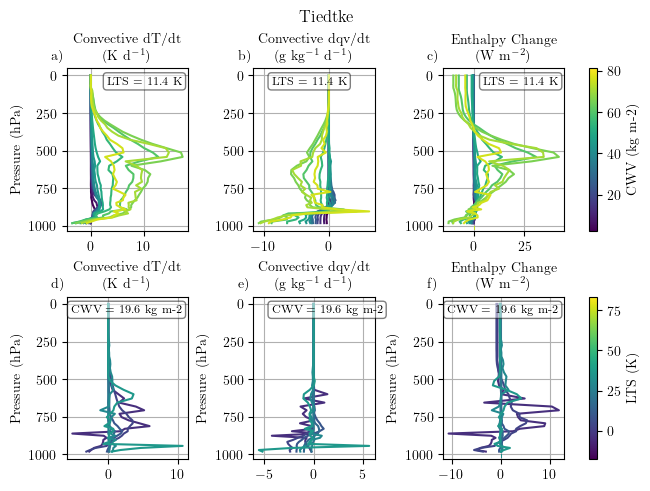

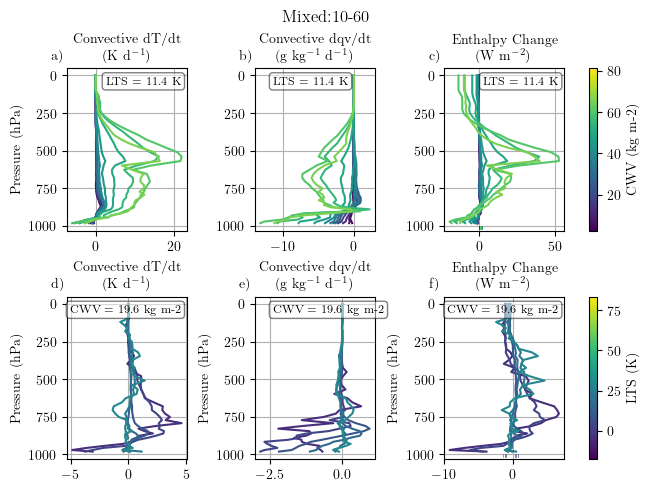

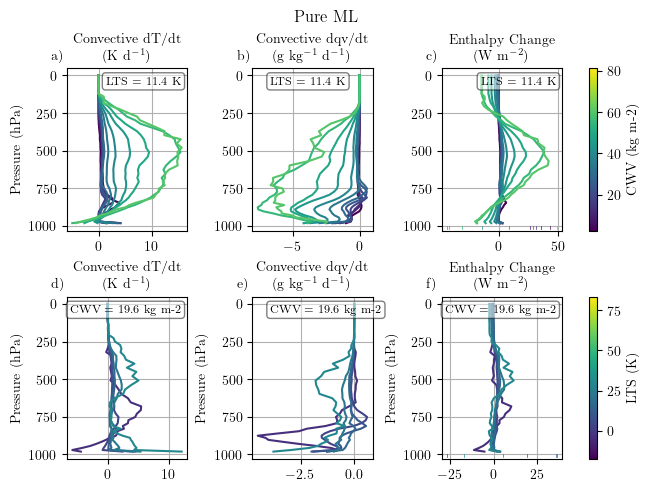

In [30]:
cmap = plt.get_cmap('viridis')
tiedtke_savepath = None#'./Figures/1d_heating-moistening-enthalpy_profiles_tiedtke.pdf'
mix_savepath = None#'./Figures/1d_heating-moistening-enthalpy_profiles_mix.pdf'
ml_savepath = None#'./Figures/1d_heating-moistening-enthalpy_profiles_ml.pdf'
plot_1d_profiles(ta_profiles_tiedtke_2d_bins, qv_profiles_tiedtke_2d_bins, e_profiles_tiedtke_2d_bins, mean_pfull_tiedtke_vals, prw_hist_mids_tiedtke, lts_hist_mids_tiedtke,
                 cmap, figsize=(6.4*1,4.8*1), suptitle='Tiedtke', savepath=tiedtke_savepath)
plot_1d_profiles(ta_profiles_mix_2d_bins, qv_profiles_mix_2d_bins, e_profiles_mix_2d_bins, mean_pfull_mix_vals, prw_hist_mids_mix, lts_hist_mids_mix,
                 cmap, figsize=(6.4*1,4.8*1), suptitle='Mixed:10-60', savepath=mix_savepath)
plot_1d_profiles(ta_profiles_ml_2d_bins, qv_profiles_ml_2d_bins, e_profiles_ml_2d_bins, mean_pfull_ml_vals, prw_hist_mids_ml, lts_hist_mids_ml,
                 cmap, figsize=(6.4*1,4.8*1), suptitle='Pure ML', savepath=ml_savepath)
plt.show()

Tiedtke mean abs enthalpy residual:  0.003283153745966653
Mix mean abs enthalpy residual:  1.023949870886281
ML mean abs enthalpy residual:  26.037469379386554


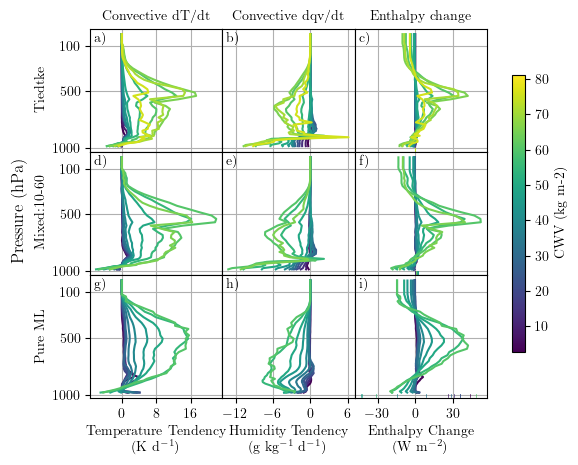

In [38]:
box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
figsize=(6.4*1.0,4.8*1.0)

# fig, ax = plt.subplots(3, 3,
#                        # constrained_layout=True,
#                        gridspec_kw=dict(hspace=0, wspace=0),
#                        figsize=figsize)

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 3, hspace=0.00, wspace=0.00, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0,0]))
axlist.append(fig.add_subplot(gs[0,1], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[0,2], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[1,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[1,1], sharey=axlist[0], sharex=axlist[1]))
axlist.append(fig.add_subplot(gs[1,2], sharey=axlist[0], sharex=axlist[2]))
axlist.append(fig.add_subplot(gs[2,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[2,1], sharey=axlist[0], sharex=axlist[1]))
axlist.append(fig.add_subplot(gs[2,2], sharey=axlist[0], sharex=axlist[2]))
ax = np.array(axlist).reshape(3,3)

# --- prw --- #
n_curves = ta_profiles_tiedtke_2d_bins.shape[0]
vertical_coord = mean_pfull_tiedtke_vals / 100

for i in range(n_curves):
    im = ax[0,0].plot(ta_profiles_tiedtke_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_tiedtke_2d_bins[i,transect_idx_lts]))
    ax[0,1].plot(qv_profiles_tiedtke_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[0,2].plot(e_profiles_tiedtke_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    ax[0,2].axvline(np.sum(e_profiles_tiedtke_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
print('Tiedtke mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_tiedtke_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

ax[0,0].set_title('Convective dT/dt', fontsize='medium')
ax[0,1].set_title('Convective dqv/dt', fontsize='medium')
ax[0,2].set_title('Enthalpy change', fontsize='medium')
# ax[0,0].text(0.95, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,0].transAxes, va='top', ha='right', bbox=box_props)
# ax[0,1].text(0.15, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,1].transAxes, va='top', ha='left', bbox=box_props)
# ax[0,2].text(0.95, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,2].transAxes, va='top', ha='right', bbox=box_props)

# fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_tiedtke[0], prw_hist_mids_tiedtke[-1]), cmap=cmap),
#              ax=ax[0,:], orientation='vertical', label=prw_label)

# --- prw --- #
n_curves = ta_profiles_mix_2d_bins.shape[0]
vertical_coord = mean_pfull_mix_vals / 100

for i in range(n_curves):
    im = ax[1,0].plot(ta_profiles_mix_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_mix_2d_bins[i,transect_idx_lts]))
    ax[1,1].plot(qv_profiles_mix_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[1,2].plot(e_profiles_mix_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    ax[1,2].axvline(np.sum(e_profiles_mix_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # print(f'Mix({i}): ', np.sum(e_profiles_mix_2d_bins[i,transect_idx_lts]))
# print(f'Mix: ', np.nansum(e_profiles_mix_2d_bins[:,transect_idx_lts]))
print('Mix mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_mix_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

# --- prw --- #
n_curves = ta_profiles_ml_2d_bins.shape[0]
vertical_coord = mean_pfull_ml_vals / 100

for i in range(n_curves):
    im = ax[2,0].plot(ta_profiles_ml_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_ml_2d_bins[i,transect_idx_lts]))
    ax[2,1].plot(qv_profiles_ml_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[2,2].plot(e_profiles_ml_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    ax[2,2].axvline(np.sum(e_profiles_ml_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # print(f'Mix2({i}): ', np.sum(e_profiles_ml_2d_bins[i,transect_idx_lts]))
print('ML mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_ml_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_ml[0], prw_hist_mids_ml[-1]), cmap=cmap),
             ax=ax[:,:], orientation='vertical', label=prw_label, shrink=0.75)#, fraction=0.01)

# for axx in ax[:,1]:
#     axx.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i,axx in enumerate(ax[:,1:].ravel()):
    axx.tick_params(left=False, labelleft=False)
    # axx.get_yaxis().set_ticklabels([])
    # axx.text(-10,1000,str(i))
    
for i,axx in enumerate(ax[:2,:].ravel()):
    axx.tick_params(bottom=False, labelbottom=False)

ax[0,0].set_yticks([100,500,1000])

# for axx in ax[:,0]:
#     axx.set_ylabel('Pressure (hPa)')
fig.supylabel('Pressure (hPa)', x=0.00)
ax[0,0].set_ylabel('Tiedtke')
ax[1,0].set_ylabel('Mixed:10-60')
ax[2,0].set_ylabel('Pure ML')

ax[2,0].set_xlabel('Temperature Tendency\n(K d$^{-1}$)')
ax[2,1].set_xlabel('Humidity Tendency\n(g kg$^{-1}$ d$^{-1}$)')
ax[2,2].set_xlabel('Enthalpy Change\n(W m$^{-2}$)')

for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
    axx.set_title(label+')', x=0.03, y=0.82, loc='left', fontsize='medium')

for i,axx in enumerate(ax.ravel()):
    axx.grid()
    axx.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    # if i == 4 or i == 1:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(3))
    # else:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(4))

ax[0,0].invert_yaxis()

# fig.savefig('./Figures/1d_heating-moistening-enthalpy_profiles_fixed-lts_vary-cwv.pdf', bbox_inches='tight')

plt.show()

In [39]:
print('Conditionally averaged mlweight for profiles (for Mix1 model)', np.nanmean(mlweight_mix2d_bins))
print('Averaged mlweight (for Mix1 model)', ds_mix.extra_2d5.mean().values)

Conditionally averaged mlweight for profiles (for Mix1 model) 0.6549186819921369
Averaged mlweight (for Mix1 model) 0.6844364


# Without enthalpy column

Tiedtke mean abs enthalpy residual:  0.003283153745966653
Mix mean abs enthalpy residual:  1.023949870886281
ML mean abs enthalpy residual:  26.037469379386554


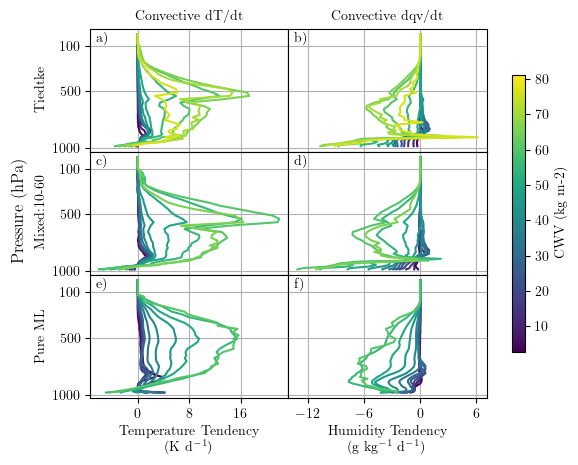

In [43]:
box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
figsize=(6.4*1.0,4.8*1.0)

# fig, ax = plt.subplots(3, 3,
#                        # constrained_layout=True,
#                        gridspec_kw=dict(hspace=0, wspace=0),
#                        figsize=figsize)

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 2, hspace=0.00, wspace=0.00, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0,0]))
axlist.append(fig.add_subplot(gs[0,1], sharey=axlist[0]))
# axlist.append(fig.add_subplot(gs[0,2], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[1,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[1,1], sharey=axlist[0], sharex=axlist[1]))
# axlist.append(fig.add_subplot(gs[1,2], sharey=axlist[0], sharex=axlist[2]))
axlist.append(fig.add_subplot(gs[2,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[2,1], sharey=axlist[0], sharex=axlist[1]))
# axlist.append(fig.add_subplot(gs[2,2], sharey=axlist[0], sharex=axlist[2]))
ax = np.array(axlist).reshape(3,2)

# --- prw --- #
n_curves = ta_profiles_tiedtke_2d_bins.shape[0]
vertical_coord = mean_pfull_tiedtke_vals / 100

for i in range(n_curves):
    im = ax[0,0].plot(ta_profiles_tiedtke_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_tiedtke_2d_bins[i,transect_idx_lts]))
    ax[0,1].plot(qv_profiles_tiedtke_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[0,2].plot(e_profiles_tiedtke_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    # ax[0,2].axvline(np.sum(e_profiles_tiedtke_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
print('Tiedtke mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_tiedtke_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

ax[0,0].set_title('Convective dT/dt', fontsize='medium')
ax[0,1].set_title('Convective dqv/dt', fontsize='medium')
# ax[0,2].set_title('Enthalpy change', fontsize='medium')
# ax[0,0].text(0.95, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,0].transAxes, va='top', ha='right', bbox=box_props)
# ax[0,1].text(0.15, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,1].transAxes, va='top', ha='left', bbox=box_props)
# ax[0,2].text(0.95, 0.95, f'LTS = {lts_hist_mids_tiedtke[transect_idx_lts]} K', fontsize='small', transform=ax[0,2].transAxes, va='top', ha='right', bbox=box_props)

# fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_tiedtke[0], prw_hist_mids_tiedtke[-1]), cmap=cmap),
#              ax=ax[0,:], orientation='vertical', label=prw_label)

# --- prw --- #
n_curves = ta_profiles_mix_2d_bins.shape[0]
vertical_coord = mean_pfull_mix_vals / 100

for i in range(n_curves):
    im = ax[1,0].plot(ta_profiles_mix_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_mix_2d_bins[i,transect_idx_lts]))
    ax[1,1].plot(qv_profiles_mix_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[1,2].plot(e_profiles_mix_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    # ax[1,2].axvline(np.sum(e_profiles_mix_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # print(f'Mix({i}): ', np.sum(e_profiles_mix_2d_bins[i,transect_idx_lts]))
# print(f'Mix: ', np.nansum(e_profiles_mix_2d_bins[:,transect_idx_lts]))
print('Mix mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_mix_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

# --- prw --- #
n_curves = ta_profiles_ml_2d_bins.shape[0]
vertical_coord = mean_pfull_ml_vals / 100

for i in range(n_curves):
    im = ax[2,0].plot(ta_profiles_ml_2d_bins[i,transect_idx_lts]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    # print(np.sum(ta_profiles_ml_2d_bins[i,transect_idx_lts]))
    ax[2,1].plot(qv_profiles_ml_2d_bins[i,transect_idx_lts]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[2,2].plot(e_profiles_ml_2d_bins[i,transect_idx_lts], vertical_coord, color=cmap(i/n_curves))
    # ax[2,2].axvline(np.sum(e_profiles_ml_2d_bins[i,transect_idx_lts]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # print(f'Mix2({i}): ', np.sum(e_profiles_ml_2d_bins[i,transect_idx_lts]))
print('ML mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_ml_2d_bins[:,transect_idx_lts], axis=-1)), axis=0))

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_ml[0], prw_hist_mids_ml[-1]), cmap=cmap),
             ax=ax[:,:], orientation='vertical', label=prw_label, shrink=0.75)#, fraction=0.01)

# for axx in ax[:,1]:
#     axx.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
for i,axx in enumerate(ax[:,1:].ravel()):
    axx.tick_params(left=False, labelleft=False)
    # axx.get_yaxis().set_ticklabels([])
    # axx.text(-10,1000,str(i))
    
for i,axx in enumerate(ax[:2,:].ravel()):
    axx.tick_params(bottom=False, labelbottom=False)

ax[0,0].set_yticks([100,500,1000])

# for axx in ax[:,0]:
#     axx.set_ylabel('Pressure (hPa)')
fig.supylabel('Pressure (hPa)', x=0.00)
ax[0,0].set_ylabel('Tiedtke')
ax[1,0].set_ylabel('Mixed:10-60')
ax[2,0].set_ylabel('Pure ML')

ax[2,0].set_xlabel('Temperature Tendency\n(K d$^{-1}$)')
ax[2,1].set_xlabel('Humidity Tendency\n(g kg$^{-1}$ d$^{-1}$)')
# ax[2,2].set_xlabel('Enthalpy Change\n(W m$^{-2}$)')

for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
    axx.set_title(label+')', x=0.03, y=0.82, loc='left', fontsize='medium')

for i,axx in enumerate(ax.ravel()):
    axx.grid()
    axx.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    # if i == 4 or i == 1:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(3))
    # else:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,0].invert_yaxis()

# fig.savefig('./Figures/1d_heating-moistening_profiles_fixed-lts_vary-cwv.pdf', bbox_inches='tight')

plt.show()

Tiedtke mean abs enthalpy residual:  0.0008031419342538963
Mix mean abs enthalpy residual:  0.34520882113526263
ML mean abs enthalpy residual:  9.307785526756197


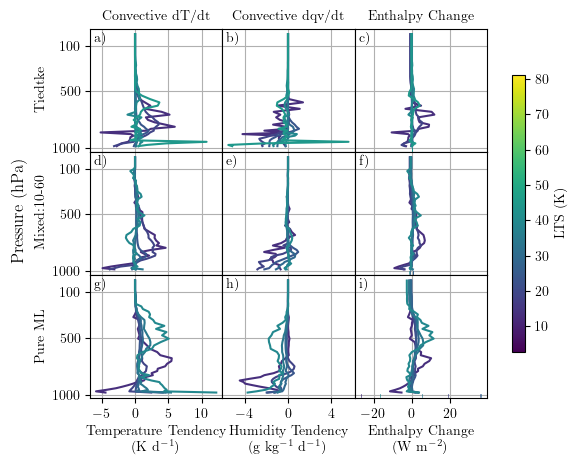

In [104]:
box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
figsize=(6.4*1,4.8*1)

# fig, ax = plt.subplots(3, 3, constrained_layout=True, figsize=figsize)

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 3, hspace=0.00, wspace=0.00, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0,0]))
axlist.append(fig.add_subplot(gs[0,1], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[0,2], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[1,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[1,1], sharey=axlist[0], sharex=axlist[1]))
axlist.append(fig.add_subplot(gs[1,2], sharey=axlist[0], sharex=axlist[2]))
axlist.append(fig.add_subplot(gs[2,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[2,1], sharey=axlist[0], sharex=axlist[1]))
axlist.append(fig.add_subplot(gs[2,2], sharey=axlist[0], sharex=axlist[2]))
ax = np.array(axlist).reshape(3,3)

# --- lts --- #
n_curves = ta_profiles_tiedtke_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[0,0].plot(ta_profiles_tiedtke_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[0,1].plot(qv_profiles_tiedtke_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[0,2].plot(e_profiles_tiedtke_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    ax[0,2].axvline(np.sum(e_profiles_tiedtke_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_tiedtke_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_tiedtke_2d_bins[transect_idx_prw,i]]))
print('Tiedtke mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_tiedtke_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

ax[0,0].set_title('Convective dT/dt', fontsize='medium')
ax[0,1].set_title('Convective dqv/dt', fontsize='medium')
ax[0,2].set_title('Enthalpy Change', fontsize='medium')

# --- lts --- #
n_curves = ta_profiles_mix_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[1,0].plot(ta_profiles_mix_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[1,1].plot(qv_profiles_mix_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[1,2].plot(e_profiles_mix_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    ax[1,2].axvline(np.sum(e_profiles_mix_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_mix_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_mix_2d_bins[transect_idx_prw,i]]))
print('Mix mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_mix_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

# --- lts --- #
n_curves = ta_profiles_ml_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[2,0].plot(ta_profiles_ml_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[2,1].plot(qv_profiles_ml_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    ax[2,2].plot(e_profiles_ml_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    ax[2,2].axvline(np.sum(e_profiles_ml_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_ml_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_ml_2d_bins[transect_idx_prw,i]]))
print('ML mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_ml_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_ml[0], prw_hist_mids_ml[-1]), cmap=cmap),
             ax=ax[:,:], orientation='vertical', label='LTS (K)', shrink=0.75)#, fraction=0.01)

for i,axx in enumerate(ax[:,1:].ravel()):
    axx.tick_params(left=False, labelleft=False)
    # axx.get_yaxis().set_ticklabels([])
    # axx.text(-10,1000,str(i))
    
for i,axx in enumerate(ax[:2,:].ravel()):
    axx.tick_params(bottom=False, labelbottom=False)

ax[0,0].set_yticks([100,500,1000])

fig.supylabel('Pressure (hPa)', x=0)
ax[0,0].set_ylabel('Tiedtke')
ax[1,0].set_ylabel('Mixed:10-60')
ax[2,0].set_ylabel('Pure ML')

ax[2,0].set_xlabel('Temperature Tendency\n(K d$^{-1}$)')
ax[2,1].set_xlabel('Humidity Tendency\n(g kg$^{-1}$ d$^{-1}$)')
ax[2,2].set_xlabel('Enthalpy Change\n(W m$^{-2}$)')

for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
    axx.set_title(label+')', x=0.03, y=0.82, loc='left', fontsize='medium')

for i,axx in enumerate(ax.ravel()):
    axx.grid()
    axx.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    # if i == 4 or i == 1:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(3))
    # else:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(4))
    
ax[0,0].invert_yaxis()

# fig.savefig('./Figures/1d_heating-moistening-enthalpy_profiles_fixed-cwv_vary-lts.pdf', bbox_inches='tight')

plt.show()

# Without enthalpy column

Tiedtke mean abs enthalpy residual:  0.0008031419342538963
Mix mean abs enthalpy residual:  0.34520882113526263
ML mean abs enthalpy residual:  9.307785526756197


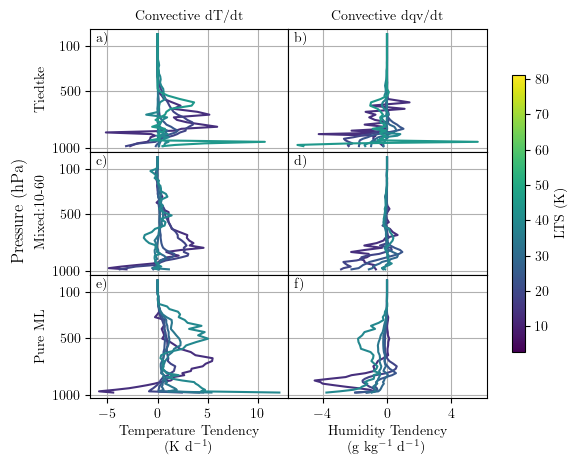

In [44]:
box_props = dict(boxstyle='round', facecolor='white', alpha=0.5)
figsize=(6.4*1,4.8*1)

# fig, ax = plt.subplots(3, 3, constrained_layout=True, figsize=figsize)

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 2, hspace=0.00, wspace=0.00, figure=fig)
axlist = []
axlist.append(fig.add_subplot(gs[0,0]))
axlist.append(fig.add_subplot(gs[0,1], sharey=axlist[0]))
# axlist.append(fig.add_subplot(gs[0,2], sharey=axlist[0]))
axlist.append(fig.add_subplot(gs[1,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[1,1], sharey=axlist[0], sharex=axlist[1]))
# axlist.append(fig.add_subplot(gs[1,2], sharey=axlist[0], sharex=axlist[2]))
axlist.append(fig.add_subplot(gs[2,0], sharey=axlist[0], sharex=axlist[0]))
axlist.append(fig.add_subplot(gs[2,1], sharey=axlist[0], sharex=axlist[1]))
# axlist.append(fig.add_subplot(gs[2,2], sharey=axlist[0], sharex=axlist[2]))
ax = np.array(axlist).reshape(3,2)

# --- lts --- #
n_curves = ta_profiles_tiedtke_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[0,0].plot(ta_profiles_tiedtke_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[0,1].plot(qv_profiles_tiedtke_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[0,2].plot(e_profiles_tiedtke_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    # ax[0,2].axvline(np.sum(e_profiles_tiedtke_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_tiedtke_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_tiedtke_2d_bins[transect_idx_prw,i]]))
print('Tiedtke mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_tiedtke_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

ax[0,0].set_title('Convective dT/dt', fontsize='medium')
ax[0,1].set_title('Convective dqv/dt', fontsize='medium')
# ax[0,2].set_title('Enthalpy Change', fontsize='medium')

# --- lts --- #
n_curves = ta_profiles_mix_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[1,0].plot(ta_profiles_mix_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[1,1].plot(qv_profiles_mix_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[1,2].plot(e_profiles_mix_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    # ax[1,2].axvline(np.sum(e_profiles_mix_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_mix_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_mix_2d_bins[transect_idx_prw,i]]))
print('Mix mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_mix_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

# --- lts --- #
n_curves = ta_profiles_ml_2d_bins.shape[1]

for i in range(n_curves):
    im = ax[2,0].plot(ta_profiles_ml_2d_bins[transect_idx_prw,i]*persec2perday, vertical_coord, color=cmap(i/n_curves))
    ax[2,1].plot(qv_profiles_ml_2d_bins[transect_idx_prw,i]*persec2perday*perg2perkg, vertical_coord, color=cmap(i/n_curves))
    # ax[2,2].plot(e_profiles_ml_2d_bins[transect_idx_prw,i], vertical_coord, color=cmap(i/n_curves))
    # ax[2,2].axvline(np.sum(e_profiles_ml_2d_bins[transect_idx_prw,i]), ymin=0.01, ymax=0.03, color=cmap(i/n_curves), linewidth=0.5)  # ymin/ymax in axes fraction
    # if np.sum(e_profiles_ml_2d_bins[transect_idx_prw,i]) > 42:
    #     print(','.join([str(x) for x in e_profiles_ml_2d_bins[transect_idx_prw,i]]))
print('ML mean abs enthalpy residual: ', np.mean(np.abs(np.nansum(e_profiles_ml_2d_bins[transect_idx_prw,:], axis=-1)), axis=0))

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(prw_hist_mids_ml[0], prw_hist_mids_ml[-1]), cmap=cmap),
             ax=ax[:,:], orientation='vertical', label='LTS (K)', shrink=0.75)#, fraction=0.01)

for i,axx in enumerate(ax[:,1:].ravel()):
    axx.tick_params(left=False, labelleft=False)
    # axx.get_yaxis().set_ticklabels([])
    # axx.text(-10,1000,str(i))
    
for i,axx in enumerate(ax[:2,:].ravel()):
    axx.tick_params(bottom=False, labelbottom=False)

ax[0,0].set_yticks([100,500,1000])

fig.supylabel('Pressure (hPa)', x=0)
ax[0,0].set_ylabel('Tiedtke')
ax[1,0].set_ylabel('Mixed:10-60')
ax[2,0].set_ylabel('Pure ML')

ax[2,0].set_xlabel('Temperature Tendency\n(K d$^{-1}$)')
ax[2,1].set_xlabel('Humidity Tendency\n(g kg$^{-1}$ d$^{-1}$)')
# ax[2,2].set_xlabel('Enthalpy Change\n(W m$^{-2}$)')

for axx, label in zip(ax.ravel(), string.ascii_lowercase[:ax.size]):
    axx.set_title(label+')', x=0.03, y=0.82, loc='left', fontsize='medium')

for i,axx in enumerate(ax.ravel()):
    axx.grid()
    axx.xaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    # if i == 4 or i == 1:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(3))
    # else:
    #     axx.xaxis.set_major_locator(plt.MaxNLocator(4))
ax[0,0].invert_yaxis()

# fig.savefig('./Figures/1d_heating-moistening_profiles_fixed-cwv_vary-lts.pdf', bbox_inches='tight')

plt.show()